In [292]:
import numpy as np
import matplotlib.pyplot as plt

In [293]:
class RandomAction:
    def __init__(self, n_states=1000, left_reward=-1):
        self.n_states = n_states
        self.left_reward = left_reward
        self.reset()

    def reset(self):
        self.state = self.n_states // 2
        return self.state

    def step(self):
        action = 0
        while action == 0:
            action = np.random.randint(-100, 101)

        self.state += action

        if self.state < 0:
            return self.state, self.left_reward, True
        elif self.state >= self.n_states:
            return self.state, 1, True
        return self.state, 0, False

In [294]:
V = np.zeros(1000)
N = np.zeros(1000)

episodes = 100000
alpha = 2e-5

FIRST_VISIT = False

env = RandomAction()

for episode in range(episodes):
    state = env.reset()

    states = []
    rewards = []

    done = False

    while not done:
        states.append(state)
        state, reward, done = env.step()
        rewards.append(reward)
        
    G = 0
    for i in reversed(range(len(states))):
        if not FIRST_VISIT or states[i] not in states[:i]:
            G = G + rewards[i]
            N[states[i]] += 1
            V[states[i]] += (G - V[states[i]]) / N[states[i]]

In [297]:
class PolyApprox:
    def __init__(self, n, do=False):
        self.n = n
        self.w = np.zeros(n+1)
        if do:
            self.do()

    def get_X(self, x):
        return np.array([x**i for i in range(self.n+1)])

    def get_V(self, x):
        return np.dot(self.w, self.get_X(x))
    
    def get_grad_V(self, x):
        return self.get_X(x)
    
    def root_average_square(self, v_hat):
        return np.sqrt(np.mean((v_hat - V)**2))

    def do(self):
        self.ras = []
        env = RandomAction()
        alpha = 0.0001
        episodes = 5000

        FIRST_VISIT = False

        for episode in range(episodes):
            state = env.reset()
            state /= 1000
            states = []
            rewards = []
            done = False

            while not done:
                states.append(state)
                state, reward, done = env.step()
                state /= 1000
                rewards.append(reward)

            G = []
            g = 0
            for i in reversed(range(len(rewards))):
                if not FIRST_VISIT or states[i] not in states[:i]:
                    g += rewards[i]
                    G.append(g)
            G.reverse()

            new_w = np.copy(self.w)
            # w <- w + alpha * (G - w^T * x) * grad(w^T * x)
            for i in range(len(G)):
                new_w += alpha * (G[i] - self.get_V(states[i])) * self.get_grad_V(states[i])
            self.w = new_w

            self.ras.append(self.root_average_square(self.get_V(np.arange(0, 1, 0.001))))

In [333]:
class CosApprox:
    def __init__(self, n, do=False):
        self.n = n
        self.w = np.zeros(n+1)
        if do:
            self.do()

    def get_X(self, x):
        return np.array([np.cos(i * np.pi * x) for i in range(self.n+1)])

    def get_V(self, x):
        return np.dot(self.w, self.get_X(x))
    
    def get_grad_V(self, x):
        return self.get_X(x)
    
    def root_average_square(self, v_hat):
        return np.sqrt(np.mean((v_hat - V)**2))

    def do(self):
        self.ras = []
        env = RandomAction()
        alpha = 0.00005
        episodes = 5000

        FIRST_VISIT = False

        for episode in range(episodes):
            state = env.reset()
            state /= 1000
            states = []
            rewards = []
            done = False

            while not done:
                states.append(state)
                state, reward, done = env.step()
                state /= 1000
                rewards.append(reward)

            G = []
            g = 0
            for i in reversed(range(len(rewards))):
                if not FIRST_VISIT or states[i] not in states[:i]:
                    g += rewards[i]
                    G.append(g)
            G.reverse()

            new_w = np.copy(self.w)
            # w <- w + alpha * (G - w^T * x) * grad(w^T * x)
            for i in range(len(G)):
                new_w += alpha * (G[i] - self.get_V(states[i])) * self.get_grad_V(states[i])
            self.w = new_w

            self.ras.append(self.root_average_square(self.get_V(np.arange(0, 1, 0.001))))

In [334]:
p_s = []

for i in range(20):
    p = [PolyApprox(i, do=True) for i in [5, 10, 20]]
    p_s.append(p)

In [338]:
c_s = []

for i in range(20):
    c = [CosApprox(i, do=True) for i in [5, 10, 20]]
    c_s.append(c)

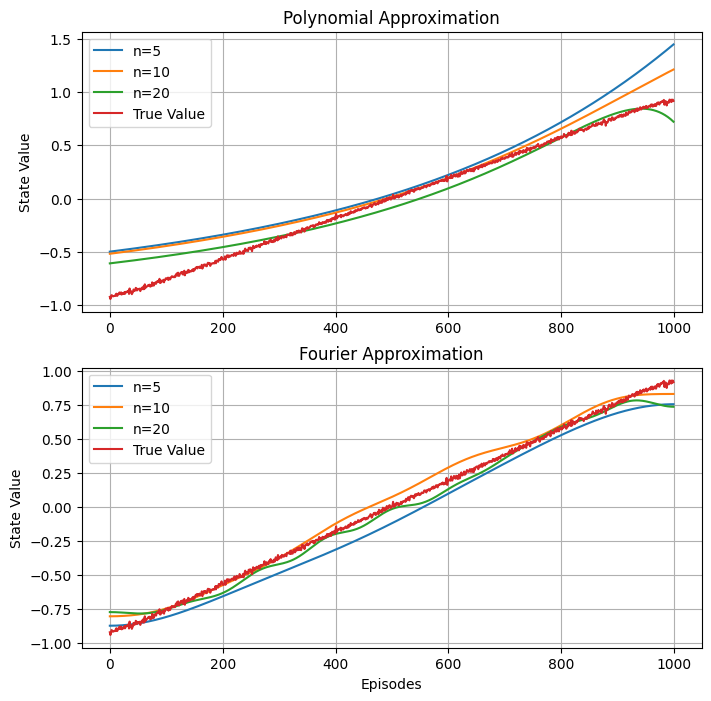

In [339]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

for i in range(3):
    ax[0].plot([p[i].get_V(x/1000) for x in range(1000)], label=f'n={p[i].n}')
    ax[1].plot([c[i].get_V(x/1000) for x in range(1000)], label=f'n={c[i].n}')

ax[0].plot(V, label='True Value')
ax[1].plot(V, label='True Value')

ax[0].title.set_text('Polynomial Approximation')
ax[1].title.set_text('Fourier Approximation')

ax[0].legend()
ax[1].legend()

ax[0].grid()
ax[1].grid()

# ax[0].set_xlabel('Episodes')
ax[1].set_xlabel('Episodes')

ax[0].set_ylabel('State Value')
ax[1].set_ylabel('State Value')

plt.show()

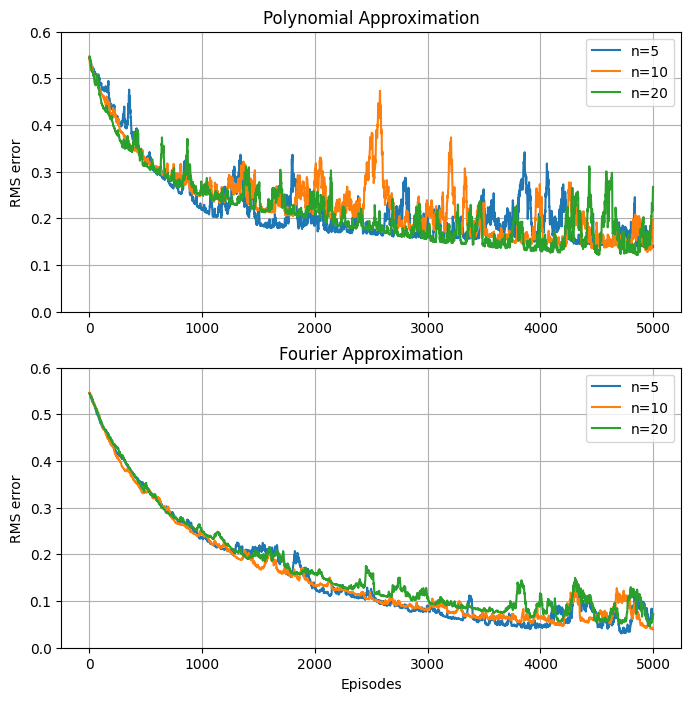

In [340]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))

for i in range(3):
    ax[0].plot(p_s[0][i].ras, label=f'n={p_s[0][i].n}')
    ax[1].plot(c_s[0][i].ras, label=f'n={c_s[0][i].n}')

ax[0].title.set_text('Polynomial Approximation')
ax[1].title.set_text('Fourier Approximation')

ax[0].legend()
ax[1].legend()

ax[0].grid()
ax[1].grid()

# ax[0].set_xlabel('Episodes')
ax[1].set_xlabel('Episodes')

ax[0].set_ylabel('RMS error')
ax[1].set_ylabel('RMS error')

ax[0].set_ylim(0, 0.6)
ax[1].set_ylim(0, 0.6)

plt.show()